In [49]:
import time

# work with directories
import os 
from pathlib import Path 

# datetime
import datetime as dt

# work with data
import numpy as np
import pandas as pd
# import pandas_datareader.data as web # not needed for this code

# visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# create bag of word vector
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# gensim
import pyLDAvis.gensim_models
from gensim.models import LdaMulticore, TfidfModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import gensim._matutils
import multiprocessing
import IPython

import warnings
warnings.filterwarnings("ignore")


### 1. Load data

Here we load the data for each company from the 'Consumer Staples' sector. The files were generated in `1_Data_Preprocessing.ipynb`

In [20]:
chd_df = pd.read_csv("data/CHD.csv")
print(chd_df.shape)
chd_df.head(5)

(70, 7)


,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus
0,FIELD OF THE INVENTION\n\nThe present inventio...,7665418,CHD,395,2/23/2010,Consumer Staples,field invent present invent relat absorb compo...
1,FIELD OF THE INVENTION\n\nThe present inventio...,7723629,CHD,395,5/25/2010,Consumer Staples,field invent present invent relat field toothb...
2,RELATED APPLICATIONS AND PATENTS\n\nThe presen...,7763454,CHD,395,7/27/2010,Consumer Staples,relat applic patent present invent relat u.s. ...
3,FIELD OF THE INVENTION\n\nThe present inventio...,7772578,CHD,395,8/10/2010,Consumer Staples,field invent present invent relat diagnost tes...
4,FIELD OF THE INVENTION\n\nThe invention relate...,7776618,CHD,395,8/17/2010,Consumer Staples,field invent invent relat diagnost assay analy...


In [21]:
cl_df = pd.read_csv("data/CL.csv")
print(cl_df.shape)
cl_df.head(5)

(335, 7)


,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus
0,This invention is directed to a dispensing con...,7690531,CL,3401,4/6/2010,Consumer Staples,invent direct dispens contain enhanc appear pa...
1,BACKGROUND OF THE INVENTION\n\nHard surface cl...,7700536,CL,3401,4/20/2010,Consumer Staples,background invent hard surfac cleaner usual wa...
2,FIELD OF THE INVENTION\n\nThe present inventio...,7703163,CL,3401,4/27/2010,Consumer Staples,field invent present invent relat toothbrush m...
3,BACKGROUND OF THE INVENTION\n\nThe efficacy of...,7704531,CL,3401,4/27/2010,Consumer Staples,background invent efficaci antiperspir salt in...
4,BACKGROUND OF THE INVENTION\n\nThe present inv...,7707677,CL,3401,5/4/2010,Consumer Staples,background invent present invent direct manual...


In [22]:
cpb_df = pd.read_csv("data/CPB.csv")
print(cpb_df.shape)
cpb_df.head(5)

(4, 7)


,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus
0,FIELD OF THE INVENTION\n\nThe present inventio...,8463423,CPB,137,6/11/2013,Consumer Staples,field invent present invent relat general syst...
1,FIELD OF THE INVENTION\n\nThe present inventio...,9066627,CPB,137,6/30/2015,Consumer Staples,field invent present invent relat instant food...
2,BACKGROUND OF THE INVENTION\n\n1. Field of Inv...,9193510,CPB,137,11/24/2015,Consumer Staples,background invent 1. field invent invent relat...
3,FIELD OF THE INVENTION\n\nThe present inventio...,9873603,CPB,137,1/23/2018,Consumer Staples,field invent present invent relat apparatus fi...


In [23]:
hsy_df = pd.read_csv("data/HSY.csv")
print(hsy_df.shape)
hsy_df.head(5)

(18, 7)


,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus
0,FIELD OF THE INVENTION AND INTRODUCTION\n\nThe...,7641930,HSY,27,1/5/2010,Consumer Staples,field invent introduct invent relat novel meth...
1,FIELD OF THE INVENTION\n\nThis invention gener...,7721908,HSY,27,5/25/2010,Consumer Staples,field invent invent general relat hand-held co...
2,FIELD OF THE INVENTION\n\nThis invention relat...,7829127,HSY,27,11/9/2010,Consumer Staples,field invent invent relat general calcium fort...
3,FIELD OF THE INVENTION AND INTRODUCTION\n\nThe...,7919135,HSY,27,4/5/2011,Consumer Staples,field invent introduct invent relat new bevera...
4,FIELD OF THE INVENTION\n\nThe invention relate...,8088431,HSY,27,1/3/2012,Consumer Staples,field invent invent relat food product ingredi...


### 2. Corpus data

Here we create the dataframes including only the patent_id and clean_corpus for each company.

In [24]:
# Helper functions

def sort_by_date(df):
    df['issue_date'] = pd.to_datetime(df['issue_date'])
    df = df.sort_values('issue_date').reset_index(drop=True)
    return df

def create_corpus(input_df):
    '''
    This function creates the corpus and remove rows with no patent data information
    
    '''
    df = input_df.set_index('patent_id')['clean_corpus']
    df.dropna(axis=0, inplace=True)
    return df

In [25]:
chd_df = sort_by_date(chd_df)
chd_corpus = create_corpus(chd_df)
chd_corpus[:5]

patent_id
7665418    field invent present invent relat absorb compo...
7723629    field invent present invent relat field toothb...
7763454    relat applic patent present invent relat u.s. ...
7772578    field invent present invent relat diagnost tes...
7776618    field invent invent relat diagnost assay analy...
Name: clean_corpus, dtype: object

In [26]:
cl_df = sort_by_date(cl_df)
cl_corpus = create_corpus(cl_df)
cl_corpus[:5]

patent_id
7690531    invent direct dispens contain enhanc appear pa...
7700536    background invent hard surfac cleaner usual wa...
7703163    field invent present invent relat toothbrush m...
7704531    background invent efficaci antiperspir salt in...
7707677    background invent present invent direct manual...
Name: clean_corpus, dtype: object

In [27]:
cpb_df = sort_by_date(cpb_df)
cpb_corpus = create_corpus(cpb_df)
cpb_corpus[:5]

patent_id
8463423    field invent present invent relat general syst...
9066627    field invent present invent relat instant food...
9193510    background invent 1. field invent invent relat...
9873603    field invent present invent relat apparatus fi...
Name: clean_corpus, dtype: object

In [28]:
hsy_df = sort_by_date(hsy_df)
hsy_corpus = create_corpus(hsy_df)
hsy_corpus[:5]

patent_id
7641930    field invent introduct invent relat novel meth...
7721908    field invent invent general relat hand-held co...
7829127    field invent invent relat general calcium fort...
7919135    field invent introduct invent relat new bevera...
8088431    field invent invent relat food product ingredi...
Name: clean_corpus, dtype: object

### 3. LDA models

In [29]:
# Helper functions

def tfidf_corpus(corpus):
    '''
    This function preprocesses a given corpus creating a dictionary, generating a Bag-of-Words representation, and
    applying TF-IDF transformation.
    
    '''
    gensim_corpus = [doc.split() for doc in corpus.to_list()]
    dictionary = Dictionary(gensim_corpus)
    ldacorpus = [dictionary.doc2bow(doc) for doc in gensim_corpus]
    tfidfmodel = TfidfModel(ldacorpus)
    tfidfmodel_corpus = tfidfmodel[ldacorpus]
    return gensim_corpus, dictionary, ldacorpus, tfidfmodel, tfidfmodel_corpus

def lda_model(corpus,num_topics):
    '''
    This function creates the LDA model for a given corpus and numer of topics.
    
    '''

    tfidf_corpus_outputs = tfidf_corpus(corpus)
    
    lda_gensim = LdaMulticore(tfidf_corpus_outputs[4], 
                          id2word=tfidf_corpus_outputs[1],
                          num_topics=num_topics,
                          workers=min(4, multiprocessing.cpu_count()-1), # number of cores
                          passes=10, # training passes
                          chunksize=200, # no. of documents in each training chuck
                         )
    return lda_gensim


#### 3.1. Optimal number of topics

To obtain the optimal number of topics for each company, we use the coherence score. Firstly, we train LDA models with different numbers of topics (5-20) for each company and compute the coherence values for each of them. Then, we identify the number of topics where the coherence value is highest or plateaus and define this number of topics as the optimal one.

In [79]:
def optimal_topics(corpus):
    # initialize list to save coherence values and lda model
    coherence_values = []
    lda_models = []

    tfidf_corpus_outputs = tfidf_corpus(corpus)

    # for each value of n
    for n in range(5, 21):

        # train the lda model with n topics
        model = LdaMulticore(tfidf_corpus_outputs[4], 
                            id2word=tfidf_corpus_outputs[1],
                            num_topics=n,
                            workers=min(8, multiprocessing.cpu_count()-1), # number of cores
                            passes=10, # training passes
                            chunksize=200, # no. of documents in each training chuck
                            )
        # add the model to the corresponding initialized list
        lda_models.append(model)
        
        # create coherence model with the above trained lda model
        coherencemodel = CoherenceModel(model=model, texts=tfidf_corpus_outputs[0], dictionary=tfidf_corpus_outputs[1], 
                                        coherence='c_v')
        
        # add the value for n and the coherence to the corresponding initialized list
        coherence_val = coherencemodel.get_coherence()
        print(n, coherence_val)
        coherence_values.append( (n, coherence_val) )
    plt.style.use('ggplot')
    plt.plot(*zip(*coherence_values))
    plt.title('Coherence Values for LDA models with Different Number of Topics\n')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence')
    plt.show()

5 0.485006302240238
6 0.4553955984665228
7 0.4741611724054395
8 0.4596810154653541
9 0.4653530972574474
10 0.43600625805385346
11 0.4579339776521774
12 0.4789659180860298
13 0.4437791787212234
14 0.4738348759797173
15 0.42806219890282166
16 0.503725311361779
17 0.4694928617769354
18 0.46902810433237785
19 0.40716777711601326
20 0.3836247253360192


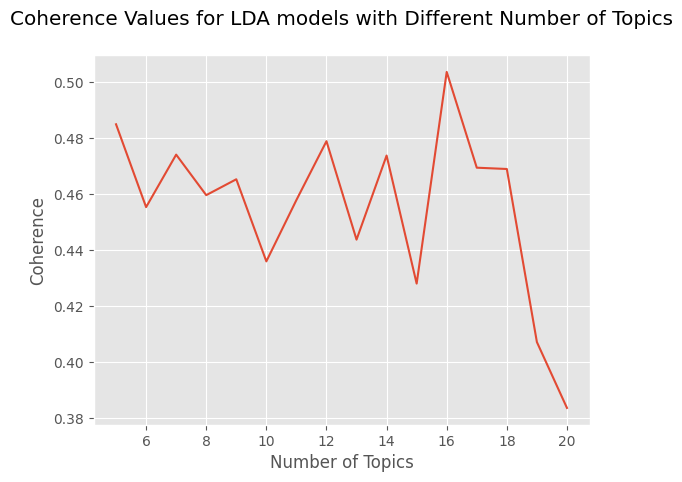

In [84]:
# CHD optimal number of topics

optimal_topics(chd_corpus)

5 0.3936834675778883
6 0.47710623129755936
7 0.48216456039179967
8 0.5107517769167129
9 0.5285537146968559
10 0.5095841459308701
11 0.5254383638004474
12 0.4856820194106614
13 0.47932422598230534
14 0.5022818673363184
15 0.5131901107692481
16 0.49744374179431033
17 0.4472186574568232
18 0.4916577973198253
19 0.48744582932343217
20 0.495206438381176


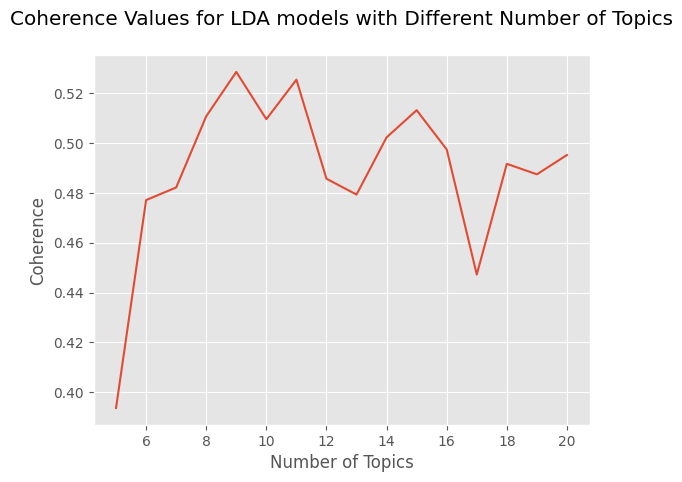

In [81]:
# CL optimal number of topics

optimal_topics(cl_corpus)

5 0.34329358638178487
6 0.3655685458566962
7 0.47081203146833284
8 0.48847711062154703
9 0.45200233392325245
10 0.4450459455373547
11 0.3403591113668281
12 0.4411014048711173
13 0.3458181847377565
14 0.2989587137888324
15 0.33815264924099003
16 0.3561616983932753
17 0.3540046435627518
18 0.3273632843360954
19 0.3537324287184389
20 0.33444013025041214


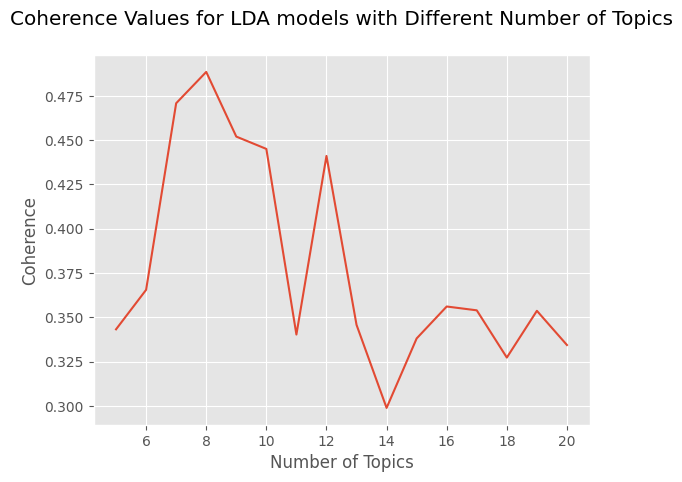

In [82]:
# CPB optimal number of topics

optimal_topics(cpb_corpus)

5 0.5944230672652
6 0.39960495614769725
7 0.46076272995045237
8 0.4457633425173243
9 0.4677771625579142
10 0.46850391137370984
11 0.48547068969559376
12 0.650068610785306
13 0.5080543159934142
14 0.4222879501647494
15 0.4782490193562236
16 0.5548336582894297
17 0.5092363652447839
18 0.4877162523891471
19 0.5719606108117703
20 0.465563483076588


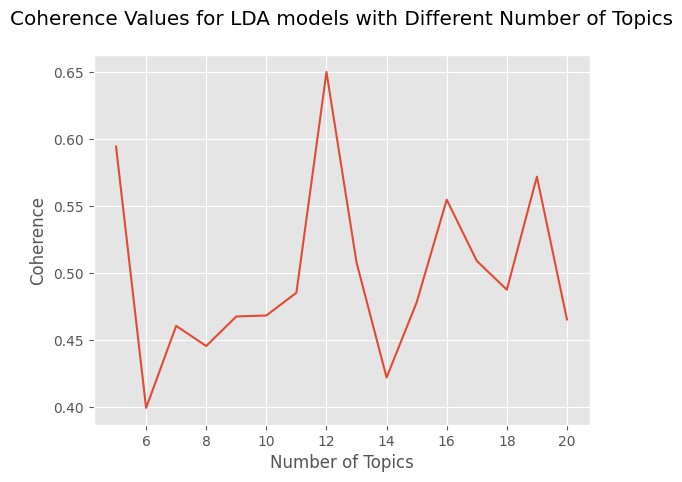

In [83]:
# HSY optimal number of topics

optimal_topics(hsy_corpus)

Optimal number of topics by company/ticker:

- CHD: 16 topics
- CL: 9 topics
- CPB: 8 topics
- HSY: 12 topics

#### 3.2. LDA model by company

After identifying the optimal number of topics, we create the LDA topic model for each company.

#### 3.2.a. CHD

In [30]:
# Model

chd_lda = lda_model(chd_corpus,16)

In [31]:
# Visualization

chd_tfidf_corpus = tfidf_corpus(chd_corpus)

pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(chd_lda, chd_tfidf_corpus[2], chd_tfidf_corpus[1])

pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_tfidf_chd' + str(16) +'.html')


In [32]:
IPython.display.HTML(filename= 'LDAvis_tfidf_chd' + str(16) +'.html')

#### 3.2.b. CL

In [33]:
# Model

cl_lda = lda_model(cl_corpus,9)

In [34]:
# Visualization

cl_tfidf_corpus = tfidf_corpus(cl_corpus)

pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(cl_lda, cl_tfidf_corpus[2], cl_tfidf_corpus[1])

pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_tfidf_cl' + str(9) +'.html')


In [35]:
IPython.display.HTML(filename= 'LDAvis_tfidf_cl' + str(9) +'.html')

#### 3.2.c. CPB

In [36]:
# Model

cpb_lda = lda_model(cpb_corpus,8)

In [37]:
# Visualization

cpb_tfidf_corpus = tfidf_corpus(cpb_corpus)

pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(cpb_lda, cpb_tfidf_corpus[2], cpb_tfidf_corpus[1],mds='tsne')

pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_tfidf_cpb' + str(8) +'.html')


In [38]:
IPython.display.HTML(filename= 'LDAvis_tfidf_cpb' + str(8) +'.html')

The presence of few relevant topics can be attributed to the limited number patents associated with this ticker (only 4).

#### 3.2.d. HSY

In [39]:
# Model

hsy_lda = lda_model(hsy_corpus,12)

In [40]:
# Visualization

hsy_tfidf_corpus = tfidf_corpus(hsy_corpus)

pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(hsy_lda, hsy_tfidf_corpus[2], hsy_tfidf_corpus[1])

pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_tfidf_hsy' + str(12) +'.html')


In [41]:
IPython.display.HTML(filename= 'LDAvis_tfidf_hsy' + str(12) +'.html')

### 4. Within-firm novelty/similarity 

To obtain a patent specific measure of novelty we:

a. Obtained the theta parameters (topics weights) for each patent.

b. Calculated the distance between a patent and the previous ones using the theta parameters and cosine similarity.

c. Created three measures by averaging the distance of one patent with the 5, 10 and 20 previous patents. 

In [50]:
# Get the theta parameters for each patent

def theta_param(corpus, model):
    theta_array = []
    tfidf_corpus_outputs = tfidf_corpus(corpus)

    for document in tfidf_corpus_outputs[4]:
        doc_topics = model.get_document_topics(document, minimum_probability=0.0)
        topic_weights = [(topic_id, weight) for topic_id, weight in doc_topics]
        theta_array.append(topic_weights)
    
    return theta_array



In [51]:
def similarity_measure(theta_array):
    '''
    This function calculates the cosine similarity between each document and the previous 5, 10 and 20 documents, 
    using the topics' weights of each patent.
    
    '''
    # Initialize an empty dataframe to store the results
    result_df = pd.DataFrame(columns=['avg_similarity_5', 'avg_similarity_10', 'avg_similarity_20'])

    # Iterate over all the documents
    for document_index in range(len(theta_array)):
        previous_documents = [i for i in range(document_index)]

        similarities = []

        for prev_index in previous_documents:
            similarity = gensim.matutils.cossim(theta_array[document_index], theta_array[prev_index])
            similarities.append(similarity)

        avg_similarity_5 = np.mean(similarities[:5])
        avg_similarity_10 = np.mean(similarities[:10])
        avg_similarity_20 = np.mean(similarities[:20])

        # Append the results to the dataframe
        result_df = result_df.append({'avg_similarity_5': avg_similarity_5,
                                    'avg_similarity_10': avg_similarity_10,
                                    'avg_similarity_20': avg_similarity_20},
                                    ignore_index=True)
    return result_df

In [52]:
chd_theta_array = theta_param(chd_corpus, chd_lda)
chd_similarity = similarity_measure(chd_theta_array)

In [53]:
cl_theta_array = theta_param(cl_corpus, cl_lda)
cl_similarity = similarity_measure(cl_theta_array)

In [54]:
cpb_theta_array = theta_param(cpb_corpus, cpb_lda)
cpb_similarity = similarity_measure(cpb_theta_array)

In [55]:
hsy_theta_array = theta_param(hsy_corpus, hsy_lda)
hsy_similarity = similarity_measure(hsy_theta_array)

Since we are measuring the distance of a patent with the previous 5, 10 and 20, for the first patent of the period we could not calculate the measurements. Also, all three measures start out the same until it get to the point where there are 10 and 20 prior patents.

### 5. Data merge

In [64]:
# Concatenate original df with new variables

chd_final = pd.concat([chd_df,chd_similarity], axis=1)
chd_final.head(5)

,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus,avg_similarity_5,avg_similarity_10,avg_similarity_20
0,FIELD OF THE INVENTION\n\nThe present inventio...,7665418,CHD,395,2010-02-23,Consumer Staples,field invent present invent relat absorb compo...,NaN,NaN,NaN
1,FIELD OF THE INVENTION\n\nThe present inventio...,7723629,CHD,395,2010-05-25,Consumer Staples,field invent present invent relat field toothb...,0.046754,0.046754,0.046754
2,RELATED APPLICATIONS AND PATENTS\n\nThe presen...,7763454,CHD,395,2010-07-27,Consumer Staples,relat applic patent present invent relat u.s. ...,0.123660,0.123660,0.123660
3,FIELD OF THE INVENTION\n\nThe present inventio...,7772578,CHD,395,2010-08-10,Consumer Staples,field invent present invent relat diagnost tes...,0.173259,0.173259,0.173259
4,FIELD OF THE INVENTION\n\nThe invention relate...,7776618,CHD,395,2010-08-17,Consumer Staples,field invent invent relat diagnost assay analy...,0.087151,0.087151,0.087151


In [60]:
cl_final = pd.concat([cl_df,cl_similarity], axis=1)
cl_final.head(5)

,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus,avg_similarity_5,avg_similarity_10,avg_similarity_20
0,This invention is directed to a dispensing con...,7690531,CL,3401,2010-04-06,Consumer Staples,invent direct dispens contain enhanc appear pa...,NaN,NaN,NaN
1,BACKGROUND OF THE INVENTION\n\nHard surface cl...,7700536,CL,3401,2010-04-20,Consumer Staples,background invent hard surfac cleaner usual wa...,0.442412,0.442412,0.442412
2,FIELD OF THE INVENTION\n\nThe present inventio...,7703163,CL,3401,2010-04-27,Consumer Staples,field invent present invent relat toothbrush m...,0.310375,0.310375,0.310375
3,BACKGROUND OF THE INVENTION\n\nThe efficacy of...,7704531,CL,3401,2010-04-27,Consumer Staples,background invent efficaci antiperspir salt in...,0.602199,0.602199,0.602199
4,BACKGROUND OF THE INVENTION\n\nThe present inv...,7707677,CL,3401,2010-05-04,Consumer Staples,background invent present invent direct manual...,0.580331,0.580331,0.580331


In [61]:
cpb_final = pd.concat([cpb_df,cpb_similarity], axis=1)
cpb_final.head(5)

,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus,avg_similarity_5,avg_similarity_10,avg_similarity_20
0,FIELD OF THE INVENTION\n\nThe present inventio...,8463423,CPB,137,2013-06-11,Consumer Staples,field invent present invent relat general syst...,NaN,NaN,NaN
1,FIELD OF THE INVENTION\n\nThe present inventio...,9066627,CPB,137,2015-06-30,Consumer Staples,field invent present invent relat instant food...,0.031251,0.031251,0.031251
2,BACKGROUND OF THE INVENTION\n\n1. Field of Inv...,9193510,CPB,137,2015-11-24,Consumer Staples,background invent 1. field invent invent relat...,0.034435,0.034435,0.034435
3,FIELD OF THE INVENTION\n\nThe present inventio...,9873603,CPB,137,2018-01-23,Consumer Staples,field invent present invent relat apparatus fi...,0.035979,0.035979,0.035979


In [62]:
hsy_final = pd.concat([hsy_df,hsy_similarity], axis=1)
hsy_final.head(5)

,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus,avg_similarity_5,avg_similarity_10,avg_similarity_20
0,FIELD OF THE INVENTION AND INTRODUCTION\n\nThe...,7641930,HSY,27,2010-01-05,Consumer Staples,field invent introduct invent relat novel meth...,NaN,NaN,NaN
1,FIELD OF THE INVENTION\n\nThis invention gener...,7721908,HSY,27,2010-05-25,Consumer Staples,field invent invent general relat hand-held co...,0.041511,0.041511,0.041511
2,FIELD OF THE INVENTION\n\nThis invention relat...,7829127,HSY,27,2010-11-09,Consumer Staples,field invent invent relat general calcium fort...,0.102424,0.102424,0.102424
3,FIELD OF THE INVENTION AND INTRODUCTION\n\nThe...,7919135,HSY,27,2011-04-05,Consumer Staples,field invent introduct invent relat new bevera...,0.291592,0.291592,0.291592
4,FIELD OF THE INVENTION\n\nThe invention relate...,8088431,HSY,27,2012-01-03,Consumer Staples,field invent invent relat food product ingredi...,0.311504,0.311504,0.311504


In [70]:
# Merge all companies

final_data = pd.concat([chd_final, cl_final, cpb_final, hsy_final])
final_data = final_data.sort_values(by='issue_date').reset_index(drop=True)

In [12]:
# Import and merge novelty sam arts

import glob

path = 'data/novelty_sam_arts/'

file_list = glob.glob(path + "novelty*.xlsx")

excl_list = []
 
for file in file_list:
    excl_list.append(pd.read_excel(file))
 
novelty_sam_arts = pd.DataFrame()
 
for excl_file in excl_list:
     
    novelty_sam_arts = novelty_sam_arts.append(
      excl_file, ignore_index=True)

C:\Users\codiz\AppData\Local\Temp\ipykernel_1352\2063394460.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  novelty_sam_arts = novelty_sam_arts.append(


In [19]:
novelty_sam_arts['patent'].duplicated().sum()

0

In [78]:
# Final dataset with sam arts novelties and measures created

all_novelty = pd.merge(final_data, novelty_sam_arts[['patent','nw', 'nb', 'nt', 'nwc', 'nov']], 
                       how="left", left_on='patent_id', right_on='patent')
all_novelty = all_novelty.drop(columns=['patent'])
all_novelty


,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus,avg_similarity_5,avg_similarity_10,avg_similarity_20,nw,nb,nt,nwc,nov
0,FIELD OF THE INVENTION AND INTRODUCTION\n\nThe...,7641930,HSY,27,2010-01-05,Consumer Staples,field invent introduct invent relat novel meth...,NaN,NaN,NaN,0.0,10.0,34.0,390.0,0.988917
1,FIELD OF THE INVENTION\n\nThe present inventio...,7665418,CHD,395,2010-02-23,Consumer Staples,field invent present invent relat absorb compo...,NaN,NaN,NaN,0.0,1.0,0.0,70.0,0.990278
2,This invention is directed to a dispensing con...,7690531,CL,3401,2010-04-06,Consumer Staples,invent direct dispens contain enhanc appear pa...,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.962962
3,BACKGROUND OF THE INVENTION\n\nHard surface cl...,7700536,CL,3401,2010-04-20,Consumer Staples,background invent hard surfac cleaner usual wa...,0.442412,0.442412,0.442412,0.0,0.0,0.0,3.0,0.983057
4,FIELD OF THE INVENTION\n\nThe present inventio...,7703163,CL,3401,2010-04-27,Consumer Staples,field invent present invent relat toothbrush m...,0.310375,0.310375,0.310375,0.0,0.0,0.0,2.0,0.976839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,FIELD OF THE INVENTION\n\nThis invention is di...,9949916,CHD,395,2018-04-24,Consumer Staples,field invent invent direct non-irrit person lu...,0.058145,0.071350,0.119110,0.0,0.0,0.0,25.0,0.983442
423,FIELD OF THE INVENTION\n\nThe invention relate...,9970923,CHD,395,2018-05-15,Consumer Staples,field invent invent relat diagnost assay analy...,0.344093,0.298935,0.188408,0.0,0.0,0.0,0.0,0.949941
424,BACKGROUND\n\nField of the Invention\n\nThe pr...,10001449,CHD,395,2018-06-19,Consumer Staples,background field invent present invent relat d...,0.244502,0.193597,0.169569,NaN,NaN,NaN,NaN,NaN
425,BACKGROUND OF THE INVENTION\n\nField of the In...,10101342,CHD,395,2018-10-16,Consumer Staples,background invent field invent present invent ...,0.365407,0.347326,0.234758,NaN,NaN,NaN,NaN,NaN


In [80]:
all_novelty.to_csv('data/all_novelty.csv', index=False) # Data to be used for prediction

### 6. Comparing novelty measures Sam Arts paper with our measures

Novelty measures Sam Arts paper:

- nw: new words 
- nb: new bigrams (two consecutive words)
- nt: new trigrams (three consecutive words)
- nwc: new word combinations
- nov: novelty (average cosine similarity between a focal patent and all patents filed in the five years before/after the focal patent)

First, we start by examining the distribution of the similarity measures created by us. It can be observed that for all three measures, the values range between 0 and 1, suggesting that the new patents are not very innovative compared to the previous ones.

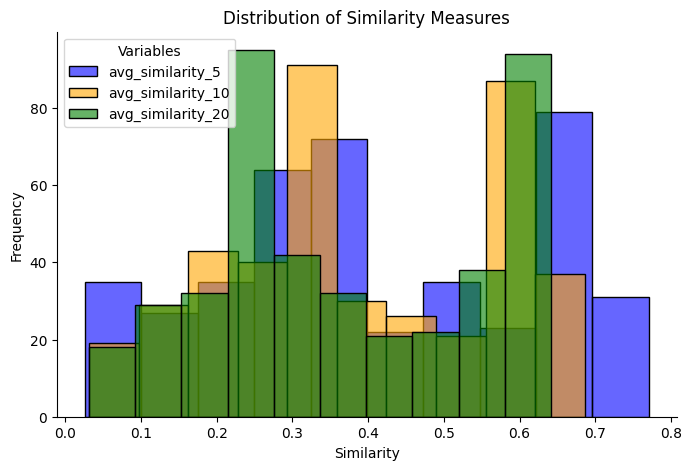

In [123]:
variables = ['avg_similarity_5', 'avg_similarity_10', 'avg_similarity_20']

fig, ax = plt.subplots(figsize=(8, 5))
colors = ['blue', 'orange', 'green']  # Custom colors for each variable

for i, variable in enumerate(variables):
    sns.histplot(data=all_novelty, x=variable, ax=ax, label=variable, color=colors[i], alpha=0.6)

ax.set_xlabel('Similarity')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Similarity Measures')
ax.legend(title='Variables')
sns.despine() 

plt.show()

Secondly, we analyze the correlation between our measures and those from the paper.

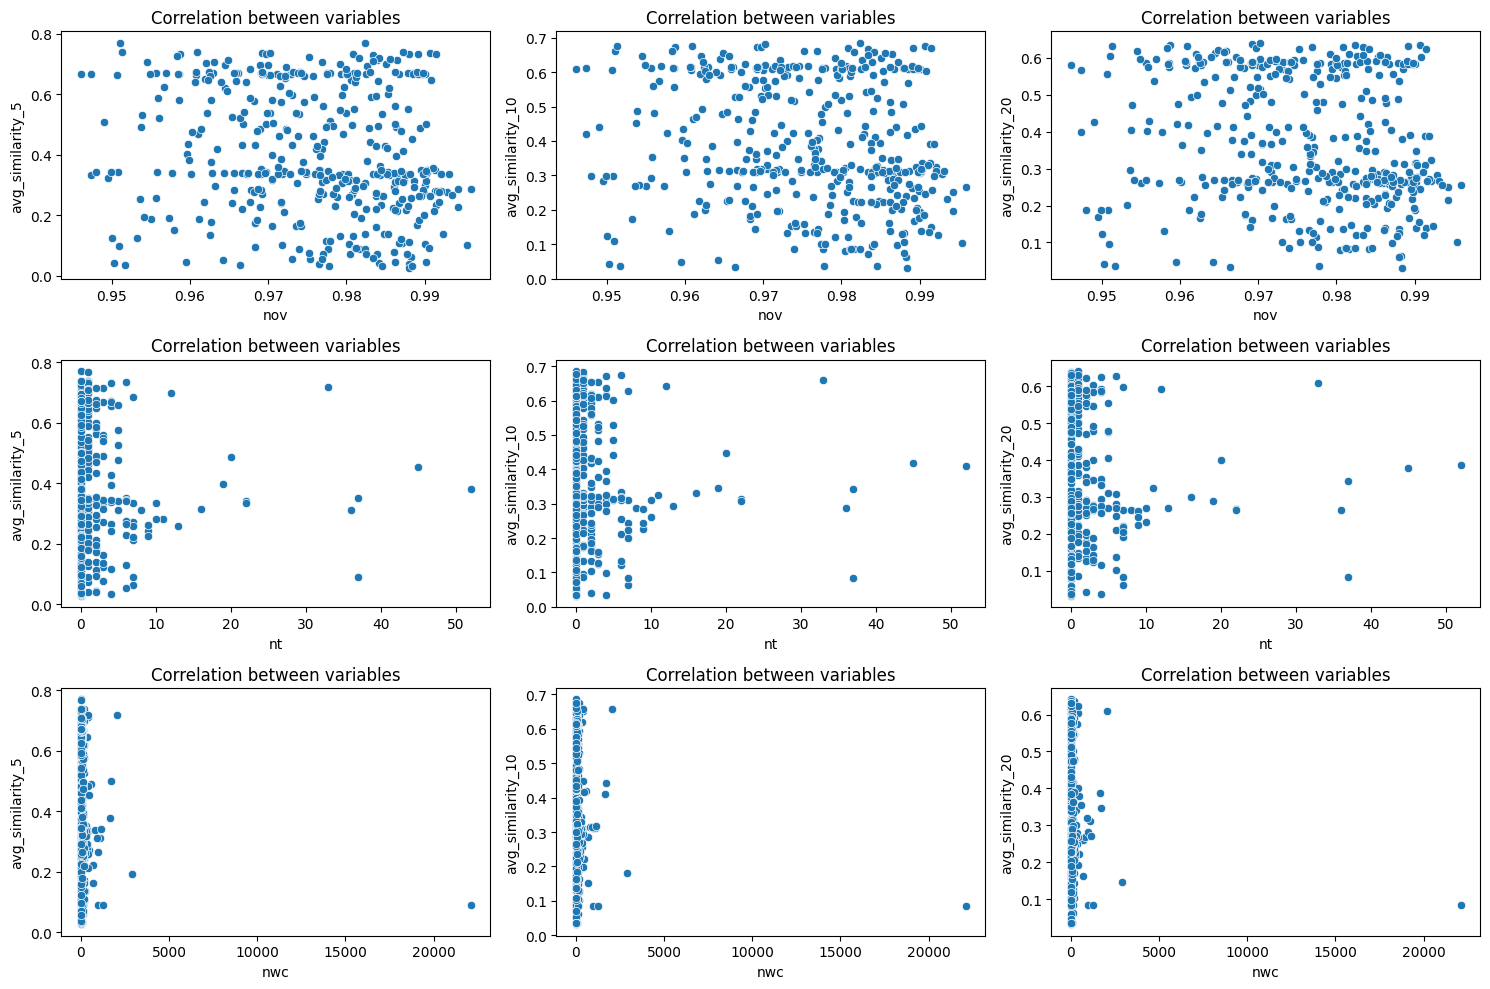

In [120]:
sams_variables = ['nov', 'nt', 'nwc']

fig, axes = plt.subplots(nrows=len(sams_variables), ncols=len(variables), figsize=(15, 10))

for i, sams_variable in enumerate(sams_variables):
    for j, variable in enumerate(variables):
        sns.scatterplot(data=all_novelty, x=sams_variable, y=variable, ax=axes[i, j])
        axes[i, j].set_xlabel(sams_variable)
        axes[i, j].set_ylabel(variable)
        axes[i, j].set_title(f'Correlation between variables')

plt.tight_layout()
plt.show()


In [96]:
correlation_5 = all_novelty['nov'].corr(all_novelty['avg_similarity_5'])
correlation_10 = all_novelty['nov'].corr(all_novelty['avg_similarity_10'])
correlation_20 = all_novelty['nov'].corr(all_novelty['avg_similarity_20'])
print("Correlation novelty - similarity(5 patents): ", correlation_5)
print("Correlation novelty - similarity(10 patents): ", correlation_10)
print("Correlation novelty - similarity(20 patents): ", correlation_20)

Correlation novelty - similarity(5 patents):  -0.1860994889198023
Correlation novelty - similarity(10 patents):  -0.1908491778282335
Correlation novelty - similarity(20 patents):  -0.18800428021669618


 In this case, we can see a low correlation by observing the graphs and a negative correlation observing the calculated coefficients. One possible explanation is that the paper directly analyzes words rather than topics, which can impact novelty since there is a higher probability of incorporating new words rather than new topics. Another reason could be that in our case, the measures compare patents within the same company, whereas the paper compares patents from different companies. Therefore, it is more likely to find greater distances between patents from different companies and sectors than within the same company over the time.